# Poem Generation using FastAI


In [2]:

from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

In [4]:
path = '' #path of where forms and topics are

In [5]:
poems = get_text_files(path, folders = ['forms','topics'])
print("There are",len(poems),"poems in the dataset")

There are 20657 poems in the dataset


In [6]:
ballads = get_text_files(path+'/forms', folders = ['ballad'])
print("There are",len(ballads),"ballads in the dataset")

There are 0 ballads in the dataset


In [7]:
txt = poems[0].open().read(); #read the first file
print(txt)

2 ABC of H.k. and China revised vision.
Barrels tears are wines and salts.
With a whisk on goody tails!
Wiggle maces to fix the heads.
Heads in jack on boxes are ceased.
Cry to paranoid truly bosses.
Bosses are jokers take your boys.
Studs are bogs with fire apples.
True predicates worth cases.â€™
Descents wash in badly bands.
Wholly sales are smart with cats.
Who got tenth honors in China?
Homage grand to play and plays!
Trim the times of hearts then cry.
Tanks in steels but voice wail.
Bossy dragged by tails that whisked.
Go very timid and love the wise.
Hands are lent but laws are ends.
Cases on courts are borrowed lands.
Length long with treads to retch!
Straps on times and watch here.
Arrays tanks but all are men.
Cross all suctions steal the ends.
Cave on minds are cages on objects.
Rouser rockets powers holes.
Confine curses to stop our wounds.
Whirl your bodies and jump on grounds.
Crouch of soldiers after kicks with flings.
Block one leg and hit the middle.
Cauchy3 know the tr

## Prepare the Data



In [8]:
ballads = L(open(o, encoding='utf-8').read() for o in ballads)


In [9]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_ballads = flatten(ballads)

In [10]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [ ]:
splits = [range_of(70), range(100)] # use a 70/30 split
tls = TfmdLists(all_ballads, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [ ]:
show_at(tls.train, 0)

The burden of hard hitting. Slug away
Like Honus Wagner or like Tyrus Cobb.
Else fandom shouteth: "Who said you could play?
Back to the jasper league, you minor slob!"
Swat, hit, connect, line out, goet on the job.
Else you shall feel the brunt of fandom's ire
Biff, bang it, clout it, hit it on the knob -
This is the end of every fan's desire.
The burden of good pitching. Curved or straight.
Or in or out, or haply up or down,
To puzzle him that standeth by the plate,
To lessen, so to speak, his bat-renown:
Like Christy Mathewson or Miner Brown,
So pitch that every man can but admire
And offer you the freedom of the town -
This is the end of every fan's desire.
The burden of loud cheering. O the sounds!
The tumult and the shouting from the throats
Of forty thousand at the Polo Grounds
Sitting, ay, standing sans their hats and coats.
A mighty cheer that possibly denotes
That Cub or Pirate fat is in the fire;
Or, as H. James would say, We've got their goats -
This is the end of every fan'

In [ ]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

Token indices sequence length is longer than the specified maximum sequence length for this model (1214 > 1024). Running this sequence through the model will result in indexing errors


In [ ]:
dls.show_batch(max_n=2)

,text,text_
0,"DOWN harvest headlands the fairy host\nOf the poppy banners have flashed and fled,\nThe lilies have faded like ghost and ghost,\nThe ripe rose rots in the garden bed.\nThe grain is garnered, the blooms are shed,\nConvolvulus springs on the snowdrop’s bier,\nIn her stranded gold is the silver thread\nOf the first grey hair i’ the head o’ the year.\nLike an arrant knave from a bootless boast,\nThe fire-wind back to his North has sped\nTo harry the manes of a haunted coast\nOn a far sea-rim where the stars are dead.\nWistful the welkin with wordless dread,\nMournful the uplands, all ashen sere—\nSad for the snow on a beauteous head—\nFor the first grey hair i’ the head o’ the year.\nTime trysts with Death at the finger-post,\nWhere the broken issues of life are wed—\nIntone no dirges, fill up the toast\nTo the troops that trip it with silent tread,\nMerry we’ll make it tho’ skies be lead","harvest headlands the fairy host\nOf the poppy banners have flashed and fled,\nThe lilies have faded like ghost and ghost,\nThe ripe rose rots in the garden bed.\nThe grain is garnered, the blooms are shed,\nConvolvulus springs on the snowdrop’s bier,\nIn her stranded gold is the silver thread\nOf the first grey hair i’ the head o’ the year.\nLike an arrant knave from a bootless boast,\nThe fire-wind back to his North has sped\nTo harry the manes of a haunted coast\nOn a far sea-rim where the stars are dead.\nWistful the welkin with wordless dread,\nMournful the uplands, all ashen sere—\nSad for the snow on a beauteous head—\nFor the first grey hair i’ the head o’ the year.\nTime trysts with Death at the finger-post,\nWhere the broken issues of life are wed—\nIntone no dirges, fill up the toast\nTo the troops that trip it with silent tread,\nMerry we’ll make it tho’ skies be lead,"
1,"you, black-bellied\nclipper,\nUp with your anchor! shake out your sails! steer straight toward\nBoston bay.\nNow call for the President's marshal again, bring out the government\ncannon,\nFetch home the roarers from Congress, make another procession, guard\nit with foot and dragoons.\nThis centre-piece for them:\nLook! all orderly citizens--look from the windows, women!\nThe committee open the box, set up the regal ribs, glue those that\nwill not stay,\nClap the skull on top of the ribs, and clap a crown on top of the\nskull.\nYou have got your revenge, old buster! The crown is come to its own,\nand more than its own.\nStick your hands in your pockets, Jonathan--you are a made man from\nthis day;",", black-bellied\nclipper,\nUp with your anchor! shake out your sails! steer straight toward\nBoston bay.\nNow call for the President's marshal again, bring out the government\ncannon,\nFetch home the roarers from Congress, make another procession, guard\nit with foot and dragoons.\nThis centre-piece for them:\nLook! all orderly citizens--look from the windows, women!\nThe committee open the box, set up the regal ribs, glue those that\nwill not stay,\nClap the skull on top of the ribs, and clap a crown on top of the\nskull.\nYou have got your revenge, old buster! The crown is come to its own,\nand more than its own.\nStick your hands in your pockets, Jonathan--you are a made man from\nthis day;"


## Fine-tuning the model

In [ ]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [ ]:
learn.validate()

C:\Users\Parth bansal\AppData\Roaming\Python\Python311\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
C:\Users\Parth bansal\AppData\Roaming\Python\Python311\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


(#2) [4.1808180809021,65.41934967041016]

SuggestedLRs(valley=7.585775892948732e-05)

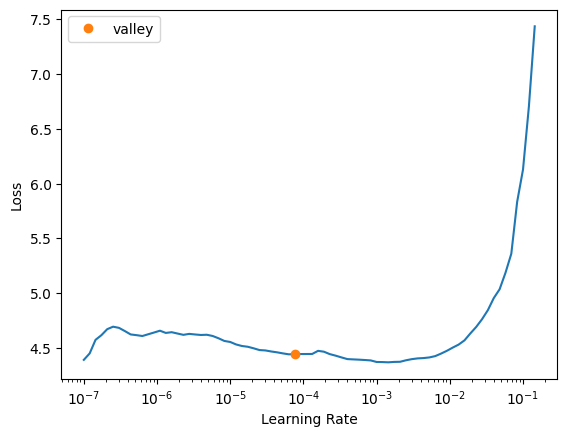

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time


## Poem Generation  

In [ ]:
prompt = 'love is all about madness' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cpu()
inp.shape

In [ ]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

In [ ]:
prompt = "I don't know what I would do"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cpu()
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I don't know what I would do with my life if I were to die."
"If I die, I shall never be able to live again," said he, "and I will never have a wife or children, nor will I ever have children of my own. I am a man
